# Multi-Channel CNN with Attention

In [34]:
!git clone https://github.com/aneeq-shaffy/SE4050-Deep-Learning.git

fatal: destination path 'SE4050-Deep-Learning' already exists and is not an empty directory.


Install Required Libraries

In [72]:
!pip install tensorflow keras pandas scikit-learn -q

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")



TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load and Explore Data

Dataset shape: (30000, 3)

Columns: ['text', 'category', 'label']

First few rows:
                                                text       category  label
0  ethan hawke julie delpy pick left midnight eth...  ENTERTAINMENT      3
1  tom cruise forced choose scientology suri tom ...  ENTERTAINMENT      3
2  would pay wine beer glass made cheese heart me...  ENTERTAINMENT      3
3                    tyga denies dating kylie jenner  ENTERTAINMENT      3
4  review laughfest subversively family friendly ...  ENTERTAINMENT      3

Unique categories: 15

Label distribution:
label
0     2000
1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
Name: count, dtype: int64

Text length statistics:
count    30000.000000
mean        17.633600
std          7.196968
min          5.000000
25%         13.000000
50%         17.000000
75%         22.000000
max        108.000000
Name: text_length, dtype:

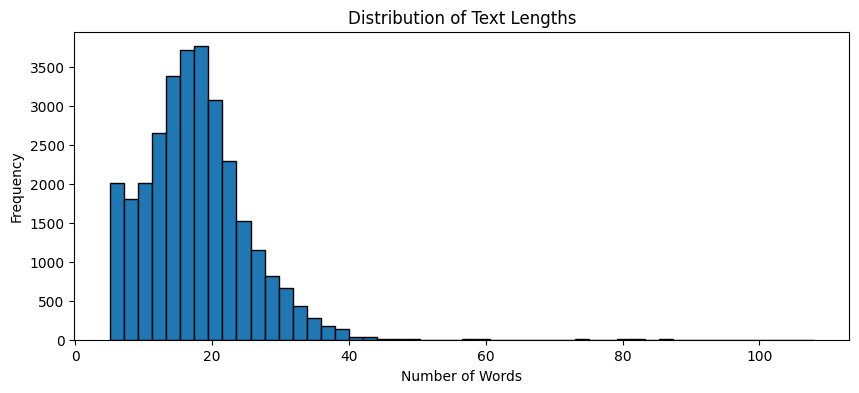

In [73]:
# Load data
df = pd.read_csv('/content/SE4050-Deep-Learning/Dataset/processed/news_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nUnique categories: {df['category'].nunique()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Check text lengths
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
print(f"\nText length statistics:")
print(df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()


Prepare Data

In [74]:
# Parameters
MAX_WORDS = 10000        # Vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Max number of words per text
EMBEDDING_DIM = 128      # Word embedding dimension

# Load data splits from pickle file
try:
    with open('/content/SE4050-Deep-Learning/Dataset/processed/data_splits.pkl', 'rb') as f:
        data_splits = pickle.load(f)

    X_train = data_splits['X_train']
    X_val = data_splits['X_val']
    X_test = data_splits['X_test']
    y_train = data_splits['y_train']
    y_val = data_splits['y_val']
    y_test = data_splits['y_test']

    print("✅ Loaded data splits from 'data_splits.pkl'")

    # Define labels from the loaded splits
    labels = np.concatenate([y_train, y_val, y_test])


except FileNotFoundError:
    print("⚠️ 'data_splits.pkl' not found. Splitting data from dataframe instead.")
    # Prepare texts and labels
    texts = df['text'].astype(str).tolist()
    labels = df['label'].values

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        texts, labels,
        test_size=0.2,
        random_state=42,
        stratify=labels
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

✅ Loaded data splits from 'data_splits.pkl'
Training samples: 21000
Validation samples: 4500
Test samples: 4500


Tokenization and Padding

In [75]:
# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")

# Get number of classes
num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")



Vocabulary size: 29124
Training data shape: (21000, 200)
Number of classes: 15


Build Custom Attention Layer

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K

class AttentionLayer(layers.Layer):
    """
    Custom Attention Layer
    Learns to focus on important parts of the text
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Attention weight matrix
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        # Attention bias
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        # Attention vector
        self.u = self.add_weight(
            name='attention_vector',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, time_steps, features)

        # Compute attention scores
        uit = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, time_steps, features)

        # Calculate attention scores by multiplying uit with the attention vector u
        # This is equivalent to a dot product with a transposed u if u was a column vector,
        # but K.dot(uit, self.u) does not work as expected with 3D and 1D tensors.
        # A common way to implement this is element-wise multiplication and sum.

        # Expand dimensions of self.u to (1, 1, features) for broadcasting
        u_expanded = K.expand_dims(K.expand_dims(self.u, axis=0), axis=0) # Shape (1, 1, features)
        # Element-wise multiplication
        weighted_uit = uit * u_expanded # Shape (batch_size, time_steps, features)
        # Sum over the last dimension to get attention scores
        ait = K.sum(weighted_uit, axis=-1) # Shape (batch_size, time_steps)


        # Apply softmax to get attention weights
        attention_weights = K.softmax(ait, axis=1)  # (batch_size, time_steps)
        attention_weights = K.expand_dims(attention_weights, axis=-1)  # (batch_size, time_steps, 1)

        # Apply attention weights to input
        weighted_input = x * attention_weights  # (batch_size, time_steps, features)

        # Sum over time steps
        output = K.sum(weighted_input, axis=1)  # (batch_size, features)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

Build Multi-Channel CNN with Attention

In [77]:
def build_multichannel_cnn_with_attention(vocab_size, embedding_dim, max_length, num_classes):
    """
    Multi-Channel CNN with Attention Architecture:
    - Embedding layer
    - Multiple parallel CNN channels with different filter sizes
    - Attention mechanism on CNN outputs
    - Dense layers for classification
    """

    # Input
    input_layer = layers.Input(shape=(max_length,), name='input')

    # Embedding layer
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        name='embedding'
    )(input_layer)

    # Dropout after embedding
    embedding = layers.Dropout(0.3, name='embedding_dropout')(embedding)

    # ============= MULTI-CHANNEL CNN =============
    # Different kernel sizes capture different n-gram patterns

    conv_outputs = []
    filter_sizes = [2, 3, 4, 5]  # Different n-gram sizes
    num_filters = 128

    for i, filter_size in enumerate(filter_sizes):
        # Convolutional layer
        conv = layers.Conv1D(
            filters=num_filters,
            kernel_size=filter_size,
            activation='relu',
            padding='same',
            name=f'conv_{filter_size}'
        )(embedding)

        # Batch normalization
        conv = layers.BatchNormalization(name=f'bn_{filter_size}')(conv)

        # Apply attention to this channel
        attention_output = AttentionLayer(name=f'attention_{filter_size}')(conv)

        conv_outputs.append(attention_output)

    # Concatenate all channels
    merged = layers.Concatenate(name='concat')(conv_outputs)

    # ============= DENSE LAYERS =============

    # First dense layer
    dense1 = layers.Dense(512, activation='relu', name='dense1')(merged)
    dense1 = layers.BatchNormalization(name='bn_dense1')(dense1)
    dense1 = layers.Dropout(0.5, name='dropout1')(dense1)

    # Second dense layer
    dense2 = layers.Dense(256, activation='relu', name='dense2')(dense1)
    dense2 = layers.BatchNormalization(name='bn_dense2')(dense2)
    dense2 = layers.Dropout(0.4, name='dropout2')(dense2)

    # Third dense layer
    dense3 = layers.Dense(128, activation='relu', name='dense3')(dense2)
    dense3 = layers.Dropout(0.3, name='dropout3')(dense3)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(dense3)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output, name='MultiChannel_CNN_Attention')

    return model

# Build the model
model = build_multichannel_cnn_with_attention(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes
)

# Display model architecture
model.summary()

# Visualize model architecture (optional)
try:
    keras.utils.plot_model(
        model,
        to_file='model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=96
    )
    print("✅ Model architecture saved as 'model_architecture.png'")
except:
    print("⚠️ Could not generate model visualization")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "MultiChannel_CNN_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 200)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,280,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_dropout   │ (None, 200, 128)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv1D)     │ (None, 200, 128)  │     32,896 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv1D)     │ (None, 200, 128)  │     49,280 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv1D)     │ (None, 200, 128)  │     65,664 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv1D)     │ (None, 200, 128)  │     82,048 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 200, 128)  │        512 │ conv_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 200, 128)  │        512 │ conv_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_4                │ (None, 200, 128)  │        512 │ conv_4[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 200, 128)  │        512 │ conv_5[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 128)       │     16,640 │ bn_2[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 128)       │     16,640 │ bn_3[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 128)       │     16,640 │ bn_4[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 128)       │     16,640 │ bn_5[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 512)       │          0 │ attention_2[0][0… │
│ (Concatenate)       │                   │            │ attention_3[0][0… │
│                     │                   │            │ attention_4[0][0… │
│                     │                   │            │ attention_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 512)       │    262,656 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_dense1           │ (None, 512)       │      2,048 │ dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,010,383 (7.67 MB)

 Trainable params: 2,007,823 (7.66 MB)

 Non-trainable params: 2,560 (10.00 KB)

✅ Model architecture saved as 'model_architecture.png'


Compile the Model

In [78]:

# Compile model with Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")



✅ Model compiled successfully!


Setup Callbacks

In [79]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_multichannel_cnn_attention.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("✅ Callbacks configured!")


✅ Callbacks configured!


Train the Model

In [43]:
# Train
print("🚀 Starting training...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Starting training...

Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1201 - loss: 3.1079
Epoch 1: val_accuracy improved from -inf to 0.06689, saving model to best_multichannel_cnn_attention.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.1203 - loss: 3.1065 - val_accuracy: 0.0669 - val_loss: 4.3070 - learning_rate: 0.0010
Epoch 2/25
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4927 - loss: 1.6520
Epoch 2: val_accuracy improved from 0.06689 to 0.44422, saving model to best_multichannel_cnn_attention.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4931 - loss: 1.6508 - val_accuracy: 0.4442 - val_loss: 1.7608 - learning_rate: 0.0010
Epoch 3/25
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6669 - loss: 1.1097
Epoch 3: val_accuracy improved from 0.44422 to 0.57711, saving model to best_multichannel_cnn_attention.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6669 - loss: 1.1100 - val_accuracy: 0.5771 - val_loss: 1.4775 - learning_rate: 0.0010
Epoch 4/25
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7568 - loss: 0.8200
Epoch 4: val_accuracy improved from 0.57711 to 0.60222, saving model to best_multichannel_cnn_attention.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7566 - loss: 0.8206 - val_accuracy: 0.6022 - val_loss: 1.5105 - learning_rate: 0.0010
Epoch 5/25
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8110 - loss: 0.6220
Epoch 5: val_accuracy did not improve from 0.60222
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8108 - loss: 0.6227 - val_accuracy: 0.5809 - val_loss: 1.6552 - learning_rate: 0.0010
Epoch 6/25
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8524 - loss: 0.4887
Epoch 6: val_accuracy did not improve from 0.60222

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8522 - loss: 0.4892 - val_accuracy: 0.5907 - val_loss: 1.8142 - learning_rate: 0.0010
Epoch 7/25
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8966 - loss: 0.3476
Epoch 7: val_accuracy did not improve from 0.60222
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8966 - loss: 0.3477 - val_a

In [44]:
# Train the model again
print("🚀 Starting training with modified model...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training with modified model...

Epoch 1/25
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7670 - loss: 0.7910
Epoch 1: val_accuracy improved from 0.60222 to 0.61556, saving model to best_multichannel_cnn_attention.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7669 - loss: 0.7913 - val_accuracy: 0.6156 - val_loss: 1.4657 - learning_rate: 5.0000e-04
Epoch 2/25
325/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8128 - loss: 0.6309
Epoch 2: val_accuracy did not improve from 0.61556
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8127 - loss: 0.6309 - val_accuracy: 0.5991 - val_loss: 1.6361 - learning_rate: 5.0000e-04
Epoch 3/25
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8650 - loss: 0.4535
Epoch 3: val_accuracy did not improve from 0.61556
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8649 - loss: 0.4538 - val_accuracy: 0.6000 - val_loss: 1.8301 - learning_rate: 5.0000e-04
Epoch 4/25
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8897 - loss: 0.3670
Epoch 4: val_accuracy did not improve from 0.61556

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8896 - loss: 0.

Plot Training History

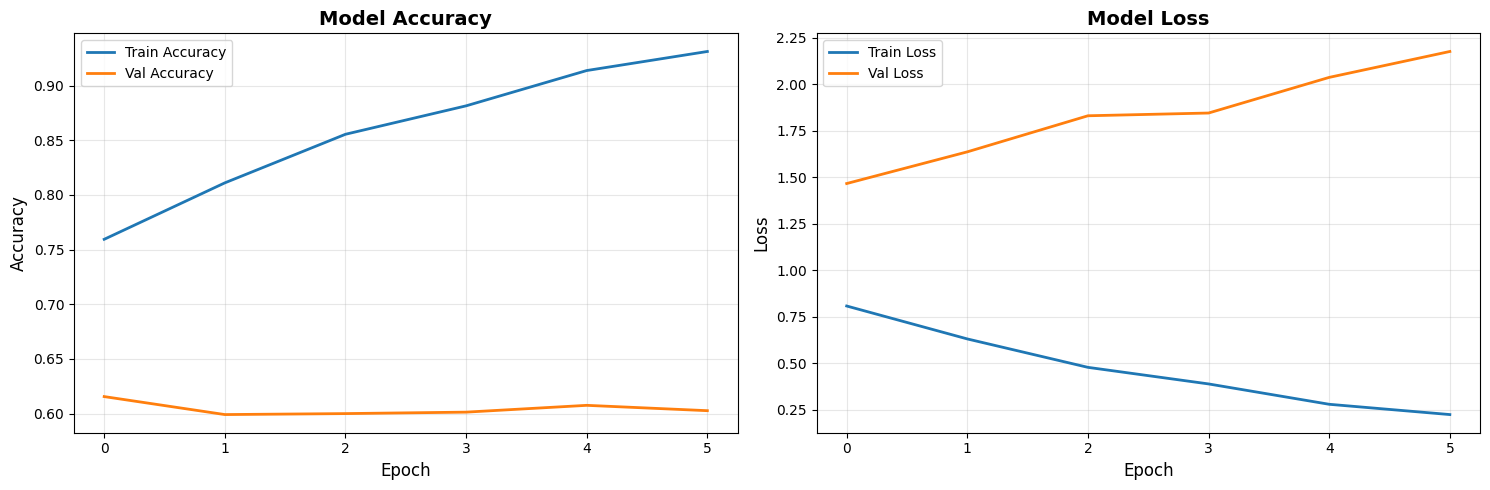

✅ Training history saved as '/content/SE4050-Deep-Learning/results/multichannel_cnn_attention_model_results/training_history.png'


In [58]:
import os

# Define the paths for the base results directory and the specific subdirectory
base_results_dir = '/content/SE4050-Deep-Learning/results'
results_subdir = os.path.join(base_results_dir, 'multichannel_cnn_attention_model_results')

# Create the directory if it doesn't exist
os.makedirs(results_subdir, exist_ok=True)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
history_plot_path = os.path.join(results_subdir, 'training_history.png')
plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Training history saved as '{history_plot_path}'")

Evaluate on Test Set

In [46]:
# Load best model
model.load_weights('best_multichannel_cnn_attention.h5')

# Predict on test set
print("📊 Evaluating on test set...\n")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\n📋 Detailed Classification Report:")
target_names = [f"Class {i}" for i in range(num_classes)]
print(classification_report(y_test, y_pred, target_names=target_names))

# Overall metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n{'='*50}")
print(f"OVERALL METRICS:")
print(f"{'='*50}")
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")


📊 Evaluating on test set...

Test Loss: 1.4870
Test Accuracy: 0.6078 (60.78%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.48      0.62      0.54       300
     Class 1       0.54      0.51      0.52       300
     Class 2       0.78      0.71      0.74       300
     Class 3       0.49      0.49      0.49       300
     Class 4       0.62      0.52      0.56       300
     Class 5       0.71      0.76      0.73       300
     Class 6       0.56      0.38      0.46       300
     Class 7       0.51      0.62      0.56       300
     Class 8       0.58      0.58      0.58       300
     Class 9       0.72      0.74      0.73       300
    Class 10       0.70      0.79      0.74       300
    Class 11       0.63      0.71      0.67       300
    Class 12       0.63      0.57      0.60       300
    Class 13       0.49      0.53      0.51       300
    Class 14       0.77      0.58      0.66       300

    accuracy         

Confusion Matrix

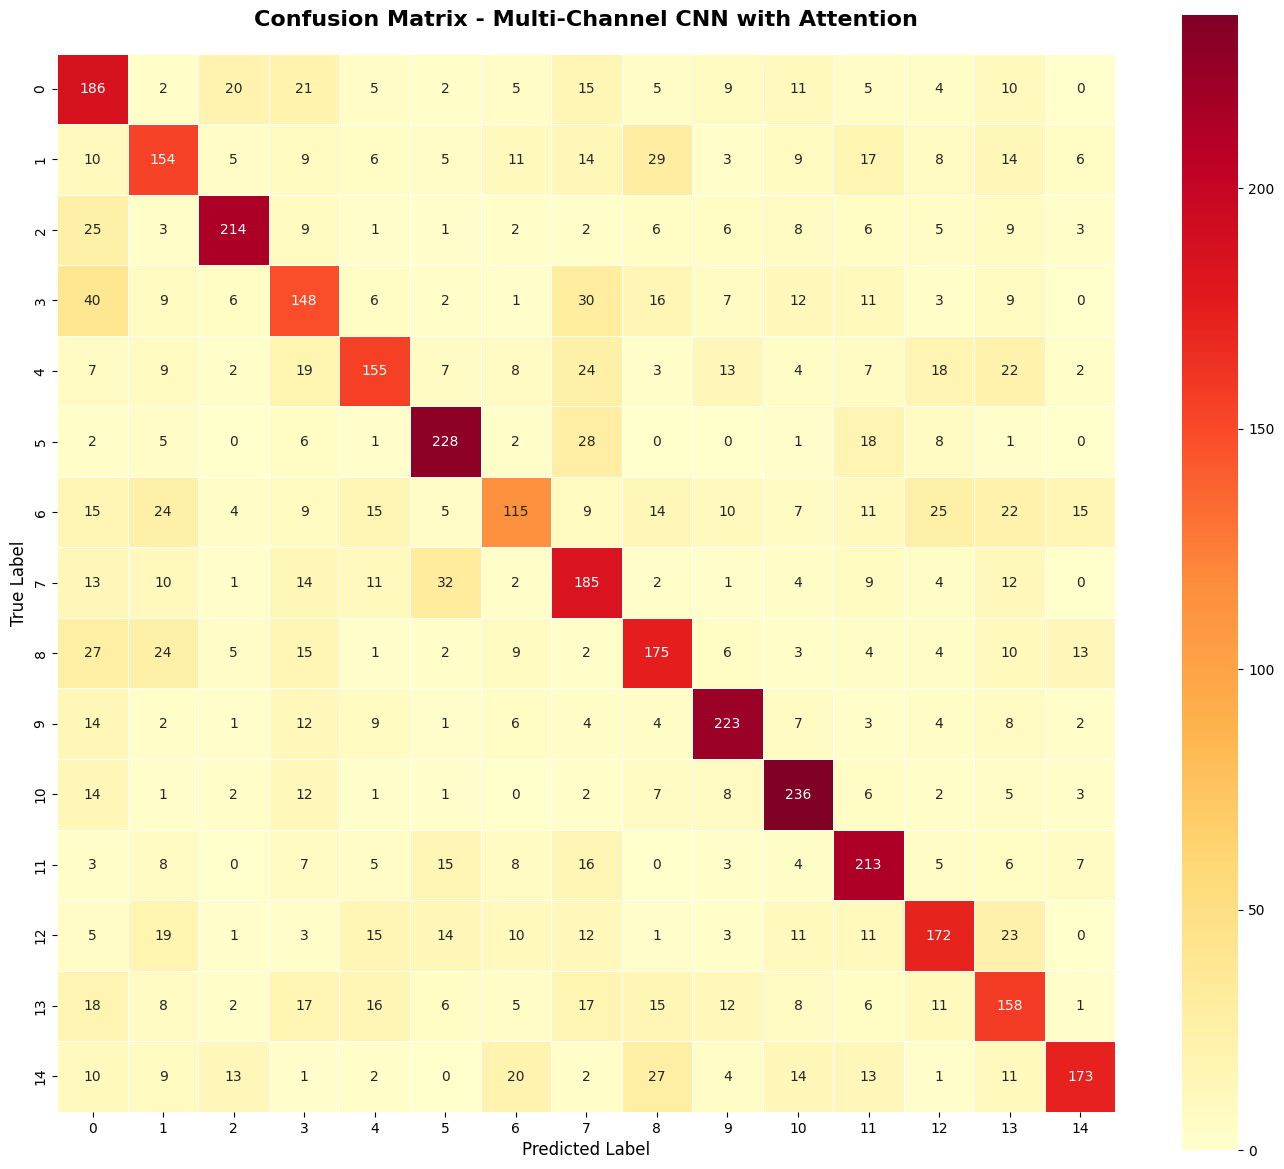

✅ Confusion matrix saved as '/content/SE4050-Deep-Learning/results/multichannel_cnn_attention_model_results/confusion_matrix.png'

PER-CLASS ACCURACY:
Class  0: 0.6200 (62.00%)
Class  1: 0.5133 (51.33%)
Class  2: 0.7133 (71.33%)
Class  3: 0.4933 (49.33%)
Class  4: 0.5167 (51.67%)
Class  5: 0.7600 (76.00%)
Class  6: 0.3833 (38.33%)
Class  7: 0.6167 (61.67%)
Class  8: 0.5833 (58.33%)
Class  9: 0.7433 (74.33%)
Class 10: 0.7867 (78.67%)
Class 11: 0.7100 (71.00%)
Class 12: 0.5733 (57.33%)
Class 13: 0.5267 (52.67%)
Class 14: 0.5767 (57.67%)


In [57]:
import os

# Define the paths for the base results directory and the specific subdirectory
base_results_dir = '/content/SE4050-Deep-Learning/results'
results_subdir = os.path.join(base_results_dir, 'multichannel_cnn_attention_model_results')

# Create the directory if it doesn't exist
os.makedirs(results_subdir, exist_ok=True)


# Confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title('Confusion Matrix - Multi-Channel CNN with Attention', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
confusion_matrix_path = os.path.join(results_subdir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix saved as '{confusion_matrix_path}'")

# Per-class accuracy
print("\n" + "="*50)
print("PER-CLASS ACCURACY:")
print("="*50)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class {i:2d}: {acc:.4f} ({acc*100:.2f}%)")

Visualize Attention Weights

In [48]:
# Create a model that outputs attention weights
def create_attention_model(trained_model):
    """
    Creates a model that outputs attention weights for visualization
    """
    attention_outputs = []
    for layer in trained_model.layers:
        if 'attention' in layer.name:
            # Get the conv layer before this attention
            conv_layer_name = layer.name.replace('attention', 'conv')
            conv_output = trained_model.get_layer(conv_layer_name).output
            attention_outputs.append(conv_output)

    if attention_outputs:
        attention_model = models.Model(
            inputs=trained_model.input,
            outputs=attention_outputs
        )
        return attention_model
    return None

# Get attention model
attention_model = create_attention_model(model)

if attention_model:
    # Visualize attention for a sample
    sample_idx = 0
    sample_text = X_test[sample_idx]
    sample_input = X_test_pad[sample_idx:sample_idx+1]

    print(f"Sample text: {sample_text[:200]}...")
    print(f"True label: {y_test[sample_idx]}")
    print(f"Predicted label: {y_pred[sample_idx]}")

    # Get attention outputs
    attention_outputs = attention_model.predict(sample_input, verbose=0)

    print("\n✅ Attention mechanism is working!")
else:
    print("⚠️ Could not create attention visualization model")


Sample text: end aid ending suffering aid possible lifetime know possible one need see investment life saving treatment drug followed stalled booming coffin making  southern africa...
True label: 6
Predicted label: 6

✅ Attention mechanism is working!


Save Model and Preprocessing Objects

In [80]:
import os

# Define the paths for the base models directory and the specific subdirectory
base_models_dir = '/content/SE4050-Deep-Learning/models'
model_subdir = os.path.join(base_models_dir, 'multichannel_cnn_attention_model')

# Create the directory if it doesn't exist
os.makedirs(model_subdir, exist_ok=True)

# Save the model
model_save_path = os.path.join(model_subdir, 'multichannel_cnn_attention_model.h5')
model.save(model_save_path)
print(f"✅ Model saved as '{model_save_path}'")

# Save tokenizer
tokenizer_save_path = os.path.join(model_subdir, 'tokenizer.pkl')
with open(tokenizer_save_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✅ Tokenizer saved as '{tokenizer_save_path}'")

# Save label mapping
label_mapping = df[['category', 'label']].drop_duplicates().sort_values('label')
label_encoder_save_path = os.path.join(model_subdir, 'label_encoder.pkl')
with open(label_encoder_save_path, 'wb') as f:
    pickle.dump(label_mapping, f)
print(f"✅ Label encoder saved as '{label_encoder_save_path}'")

# Save config
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'num_classes': num_classes,
    'filter_sizes': [2, 3, 4, 5],
    'num_filters': 128
}
config_save_path = os.path.join(model_subdir, 'model_config.pkl')
with open(config_save_path, 'wb') as f:
    pickle.dump(config, f)
print(f"✅ Config saved as '{config_save_path}'")

print("\n" + "="*50)
print("ALL FILES SAVED SUCCESSFULLY!")
print("="*50)

✅ Model saved as '/content/SE4050-Deep-Learning/models/multichannel_cnn_attention_model/multichannel_cnn_attention_model.h5'
✅ Tokenizer saved as '/content/SE4050-Deep-Learning/models/multichannel_cnn_attention_model/tokenizer.pkl'
✅ Label encoder saved as '/content/SE4050-Deep-Learning/models/multichannel_cnn_attention_model/label_encoder.pkl'
✅ Config saved as '/content/SE4050-Deep-Learning/models/multichannel_cnn_attention_model/model_config.pkl'

ALL FILES SAVED SUCCESSFULLY!


Test Predictions

In [81]:
def predict_text(text, model, tokenizer, label_mapping, max_length):
    """Predict category for a given text with top-k predictions"""

    # Preprocess
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded, verbose=0)
    pred_label = np.argmax(prediction[0])
    confidence = prediction[0][pred_label]

    # Get category name
    category = label_mapping[label_mapping['label'] == pred_label]['category'].values[0]

    print("="*70)
    print(f"Text: {text[:150]}...")
    print("-"*70)
    print(f"✅ Predicted Category: {category}")
    print(f"✅ Confidence: {confidence*100:.2f}%")
    print("-"*70)
    print("Top 5 predictions:")
    top_5_idx = np.argsort(prediction[0])[-5:][::-1]
    for rank, idx in enumerate(top_5_idx, 1):
        cat = label_mapping[label_mapping['label'] == idx]['category'].values[0]
        prob = prediction[0][idx] * 100
        bar = "█" * int(prob / 2)
        print(f"  {rank}. {cat:20s} {prob:5.2f}% {bar}")
    print("="*70)
    print()

# Test with multiple examples
test_texts = [
    "The Lakers won the championship game last night with an incredible performance",
    "New study shows benefits of meditation for mental health and stress reduction",
    "Stock market reaches all-time high today as investors remain optimistic",
    "Tips for healthy eating and meal preparation for busy professionals",
    "President announces new policy changes affecting international relations",
    "Scientists discover breakthrough in renewable energy technology",
    "Celebrity couple announces engagement on social media platform",
    "Travel guide to the most beautiful destinations in Europe this summer"
]

print("\n" + "🔮 TESTING PREDICTIONS ".center(70, "=") + "\n")

for text in test_texts:
    predict_text(text, model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)



========================🔮 TESTING PREDICTIONS ========================

Text: The Lakers won the championship game last night with an incredible performance...
----------------------------------------------------------------------
✅ Predicted Category: WORLDPOST
✅ Confidence: 6.84%
----------------------------------------------------------------------
Top 5 predictions:
  1. WORLDPOST             6.84% ███
  2. BUSINESS              6.75% ███
  3. LIFESTYLE             6.73% ███
  4. FAMILY                6.71% ███
  5. IMPACT                6.71% ███

Text: New study shows benefits of meditation for mental health and stress reduction...
----------------------------------------------------------------------
✅ Predicted Category: WORLDPOST
✅ Confidence: 6.84%
----------------------------------------------------------------------
Top 5 predictions:
  1. WORLDPOST             6.84% ███
  2. BUSINESS              6.75% ███
  3. LIFESTYLE             6.72% ███
  4. FAMILY                6.

Load Model Later (For Future Use)

In [51]:
# Complete loading script for later use
from tensorflow import keras
import pickle

# Custom objects for loading model with attention layer
custom_objects = {'AttentionLayer': AttentionLayer}

# Load model
loaded_model = keras.models.load_model(
    'multichannel_cnn_attention.h5',
    custom_objects=custom_objects
)

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Load label mapping
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_mapping = pickle.load(f)

# Load config
with open('model_config.pkl', 'rb') as f:
    loaded_config = pickle.load(f)

print("✅ All components loaded successfully!")
print(f"Model ready for predictions with {loaded_config['num_classes']} classes")

# Test prediction with loaded model
predict_text(
    "Breaking news about political developments in Washington",
    loaded_model,
    loaded_tokenizer,
    loaded_label_mapping,
    loaded_config['MAX_SEQUENCE_LENGTH']
)


✅ All components loaded successfully!
Model ready for predictions with 15 classes
Text: Breaking news about political developments in Washington...
----------------------------------------------------------------------
✅ Predicted Category: POLITICS
✅ Confidence: 72.15%
----------------------------------------------------------------------
Top 5 predictions:
  1. POLITICS             72.15% ████████████████████████████████████
  2. WORLDPOST            12.95% ██████
  3. ENTERTAINMENT         9.57% ████
  4. WOMEN                 1.58% 
  5. BUSINESS              0.92% 

